# Herron Topic 4 - Portfolio Optimization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.optimize as sco # new addition for portfolio optimization
import statsmodels.api as sm
import yfinance as yf

In [3]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Introduction

This notebook covers portfolio optimization.
In this notebook, we will:

1. Review the 1/N portfolio (or equal-weighted portfolio) from the Herron topic 1 notebook
1. Use SciPy's `minimize()` function to:
    1. Find the minimum-variance portfolio
    1. Find the minimum-variance frontier

Ivo Welch provides a clear discussion of the theory and practice of portfolio optimization in Chapter 12 of [his free investments textbook](https://corpfin.ivo-welch.info/bookg.pdf).

## The 1/N Portfolio

We first saw the 1/N portfolio (or equal-weighted portfolio) in the Herron topic 1 notebook.
The 1/N portfolio gives each of N assets an equal portfolio weight of 1/N.
While the 1/N strategy seems too simple to be useful, @demiguel2009optimal show the 1/N portfolio typically has a higher mean-variance efficiency than advanced portfolio optimizations.

We will investigate the 1/N portfolio and portfolio optimization with the most recent three years of daily returns for the Mag 7 stocks (i.e., GOOGL, AMZN, AAPL, META, MSFT, NVDA, and TSLA).

In [4]:
mag7 = (
    yf.download(
        tickers='GOOGL AMZN AAPL META MSFT NVDA TSLA',
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1] # drop incomplete trading day
)

In [5]:
returns = (
    mag7
    ['Adj Close']
    .pct_change()
    .iloc[(-3 * 252):]
)

We can manually calculate 1/N portfolio returns three ways.

The first calculation is a literal interpretation of $r_P = \frac{1}{N} \sum_{i}^{N} r_i$.
The pandas code for this first calculation is `returns.sum(axis=1).div(n)`, which sums across the rows, and then divides by `n`.
Recall that with constant weights, we rebalance our portfolio every return period.
If we have daily data, we rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

In [6]:
n = returns.shape[1]
r_p1 = returns.sum(axis=1).div(n)

In [8]:
r_p1.describe()

count   756.0000
mean      0.0010
std       0.0196
min      -0.0674
25%      -0.0099
50%       0.0007
75%       0.0127
max       0.0984
dtype: float64

We learned the last two calculations in the Herron topic 1.
The pandas code for the second calculation is `returns.mean(axis=1)`, which calculates the mean of each row.

In [9]:
r_p2 = returns.mean(axis=1)

In [10]:
r_p2.describe()

count   756.0000
mean      0.0010
std       0.0196
min      -0.0674
25%      -0.0099
50%       0.0007
75%       0.0127
max       0.0984
dtype: float64

The pandas code for the third calculations is `returns.dot(weights)`, where `weights` is a NumPy array or a pandas series of portfolio weights.
This calculation allows different weights for each asset.
We can make 1/N portfolio weights with `np.ones(n) / n`.

In [11]:
weights = np.ones(n) / n

In [12]:
weights

array([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429])

In [13]:
r_p3 = returns.dot(weights)

In [14]:
r_p3.describe()

count   756.0000
mean      0.0010
std       0.0196
min      -0.0674
25%      -0.0099
50%       0.0007
75%       0.0127
max       0.0984
dtype: float64

We can use `np.allclose()` to show that `r_p1`, `r_p2`, and `r_p3` are similar.

In [15]:
np.allclose(r_p1, r_p2)

True

In [16]:
np.allclose(r_p2, r_p3)

True

In [17]:
np.allclose(r_p3, r_p1)

True

---

Here is a brief detour to show how the `.dot()` method works.

In [18]:
silly_n = 3
silly_w = np.ones(silly_n) / silly_n
silly_r = pd.DataFrame(np.arange(2*silly_n).reshape(2, silly_n))

In [19]:
print(
    f'silly_n:\n{silly_n}',
    f'silly_w:\n{silly_w}',
    f'silly_r:\n{silly_r}',
    sep='\n\n'
)

silly_n:
3

silly_w:
[0.3333 0.3333 0.3333]

silly_r:
   0  1  2
0  0  1  2
1  3  4  5


In [20]:
silly_r.dot(silly_w)

0   1.0000
1   4.0000
dtype: float64

Under the hood, the `.dot()` method efficiently calculates the following:

In [21]:
for i, row in silly_r.iterrows():
    print(
        f'Row {i}: ',
        ' + '.join([f'{w:0.2f} * {y}' for w, y in zip(silly_w, row)]),
        ' = ',
        f'{silly_r.dot(silly_w).iloc[i]:0.2f}'
    )

Row 0:  0.33 * 0 + 0.33 * 1 + 0.33 * 2  =  1.00
Row 1:  0.33 * 3 + 0.33 * 4 + 0.33 * 5  =  4.00


---

## SciPy's `minimize()` Function

SciPy's `minimize()` function, from the `optimize` module, finds the input array `x` that minimizes the output of a given function `fun`.
The `minimize()` function uses optimization techniques that are beyond the scope of this course.
We can consider these optimization techniques as sophisticated trial-and-error (or guess-and-check).

Here are the common arguments for the the `minimize()` function:

1. `fun=` is the name of the function who's output we want to minimize
1. `x0=` is our first guess for the input to the function `fun`
1. `args=` is a tuple of additional arguments to the function `fun`
1. `bounds=` is a tuple of tuples with lower and upper bounds for each element in `x`
1. `contraints=` is a tuple of dictionaries that limit `x` by constraining the output of a given function to zero or non-negative values

Here is a simple example that minimizes the function `quadratic()`, which has arguments $x$ and $a$ and returns $(x - a)^2$.

In [22]:
def quadratic(x, a=5):
    return (x - a) ** 2

In [23]:
quadratic(x=0, a=5)

25

In [24]:
quadratic(x=5, a=5)

0

In [25]:
quadratic(x=10, a=5)

25

It might be helpful to plot $y = (x - a)^2$.

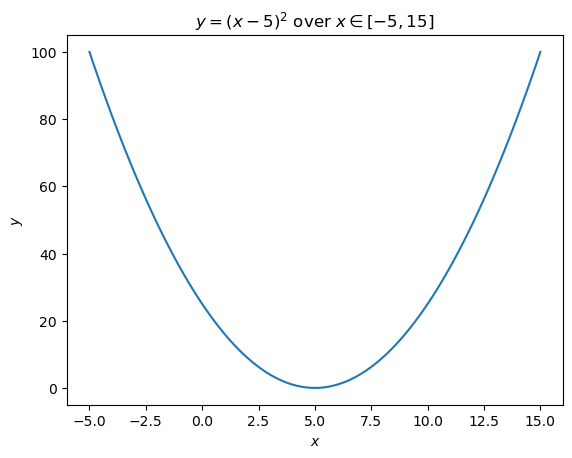

In [26]:
x = np.linspace(-5, 15, 101)
y = quadratic(x=x)
plt.plot(x, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = (x - 5)^2$ over $x \in [-5, 15]$')
plt.show()

The minimum output of `quadratic()` occurs at $x=5$ if we do not use bounds or constraints.
For this function, we can even start far away from $x=5$.

In [27]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001])
)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0392713450495178e-16
        x: [ 5.000e+00]
      nit: 4
      jac: [-1.366e-08]
 hess_inv: [[ 5.000e-01]]
     nfev: 18
     njev: 9

The minimum output of `quadratic()` occurs at $x=6$ if we bound $6 \leq x \leq 10$ with `bounds=((6, 10),)`.
`bounds=` requires a tuple of tuples, so we need the trailing comma if we only have one set of bounds.

In [28]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((6, 10),)
)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.0
        x: [ 6.000e+00]
      nit: 1
      jac: [ 2.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

The minimum output of `quadratic()` also occurs at $x=6$ if we constrain $x-6 \geq 0$ with `constraints=({'type': 'ineq', 'fun': lambda x: x - 6})`.
For inequality constraints, the given function must evaluate to a non-negative value.
We use bounds to limit the search space directly, and we use constraints to limit the search space based on a given function.

In [29]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    constraints=({'type': 'ineq', 'fun': lambda x: x - 6})
)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.0000000000000018
       x: [ 6.000e+00]
     nit: 3
     jac: [ 2.000e+00]
    nfev: 6
    njev: 3

We use the `args=` argument to pass additional arguments to the function `fun`.
For example, we change the `a=` argument in `quadratic()` from the default of `a=5` to `a=20` with `args=(20,)`.
Like `bounds=`, `args=` expects a tuple, so we need a trailing comma if we have only one argument.

In [30]:
sco.minimize(
    fun=quadratic,
    args=(20,),
    x0=np.array([2001]),
)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.090392030754976e-17
        x: [ 2.000e+01]
      nit: 4
      jac: [-1.940e-09]
 hess_inv: [[ 5.000e-01]]
     nfev: 18
     njev: 9

## The Minimum-Variance Portfolio

Now we apply `minimize()` to our Mag-7 returns to find the the minimum-variance portfolio.
Recall, the `minimize()` function varies an input array `x`, starting from argument `x0=`, to minimize the output of a given function `fun=` subject to the bounds and constraints in `bounds=` and `constraints=`, respectively. 

We can define a function `calc_sigmap()` to calculate portfolio volatility.
The first argument to `calc_sigmap()` must be the input array `x` that `minimize()` searches over.
We call this first argument `w` because it has portfolio weights.
Recall that portfolio variance is $\sigma^2_p = w' \Sigma w$, so portfolio volatility is $\sigma_p = \sqrt{w' \Sigma w}$.
Here $\Sigma$ (and `Sigma`) is the returns covariance matrix, and $w$ (and `w`) is the portfolio weights array.

In [31]:
def calc_sigmap(w, Sigma, ppy=252):
    return np.sqrt(ppy * w.T @ Sigma @ w)

In [32]:
Sigma = returns.cov()

In [33]:
Sigma

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Ticker,,,,,,,
AAPL,0.0003,0.0002,0.0002,0.0002,0.0002,0.0003,0.0003
AMZN,0.0002,0.0005,0.0003,0.0004,0.0003,0.0004,0.0004
GOOGL,0.0002,0.0003,0.0004,0.0003,0.0002,0.0004,0.0003
META,0.0002,0.0004,0.0003,0.0008,0.0003,0.0005,0.0004
MSFT,0.0002,0.0003,0.0002,0.0003,0.0003,0.0004,0.0003
NVDA,0.0003,0.0004,0.0004,0.0005,0.0004,0.0012,0.0006
TSLA,0.0003,0.0004,0.0003,0.0004,0.0003,0.0006,0.0015


We can also define a function `calc_mup()` that calculates a mean portfolio return.
Recall that mean portfolio return is $\mu_p = w' \mu$.
Here $\mu$ (and `mu`) is the mean returns array, and $w$ (and `w`) is the portfolio weights array.

In [34]:
def calc_mup(w, mu, ppy=252):
    return ppy * w.T @ mu

In [35]:
mu = returns.mean()

In [36]:
mu

Ticker
AAPL    0.0005
AMZN    0.0005
GOOGL   0.0004
META    0.0018
MSFT    0.0005
NVDA    0.0025
TSLA    0.0005
dtype: float64

Finally, we can use `minimize()` to find the portfolio weights that minimize portfolio volatility.
Below, the equality constraint is met when `x.sum() - 1` is zero, which is the Python equivalent of $\sum_i w_i = 1$.

In [39]:
[(0,1) for _ in Sigma]

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [ ]:
res_mv = sco.minimize(
    fun=calc_sigmap,
    x0=np.ones(Sigma.shape[0]) / Sigma.shape[0],
    args=(Sigma, 252),
    bounds=[(0,1) for _ in Sigma],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1},
    )
)

In [41]:
print(res_mv)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2434752847371044
       x: [ 4.614e-01  0.000e+00  9.627e-02  2.819e-18  4.423e-01
            4.207e-17  9.975e-18]
     nit: 10
     jac: [ 2.435e-01  2.573e-01  2.435e-01  2.770e-01  2.435e-01
            3.424e-01  3.046e-01]
    nfev: 80
    njev: 10


What are the attributes of the minimum-variance portfolio?
We can write a helper function `print_port_res()` to simplify our lives!

In [44]:
def print_port_res(w, mu, Sigma, title, ppy=252):
    width = max(len(title), 32)
    mup = ppy * w.T @ mu
    sigmap = np.sqrt(ppy * w.T @ Sigma @ w)
    
    return print(
        title,
        '=' * width,
        '',
        'Performance',
        '-' * width,
        'Annualized Mean Return:'.ljust(width - 6) + f'{mup:0.4f}',
        'Annualized Volatility:'.ljust(width - 6) + f'{sigmap:0.4f}',
        '',
        'Weights', 
        '-' * width, 
        '\n'.join([
            f'{_r}:'.ljust(width - 6) + f'{_w:0.4f}' 
            for _r, _w in zip(Sigma.index, w)
        ]),
        '=' * width, 
        sep='\n',
    )

In [45]:
print_port_res(
    w=res_mv['x'],
    mu=returns.mean(),
    Sigma=returns.cov(),
    title='minimum-variance portfolio'
)

minimum-variance portfolio

Performance
--------------------------------
Annualized Mean Return:   0.1292
Annualized Volatility:    0.2435

Weights
--------------------------------
AAPL:                     0.4614
AMZN:                     0.0000
GOOGL:                    0.0963
META:                     0.0000
MSFT:                     0.4423
NVDA:                     0.0000
TSLA:                     0.0000


## The Minimum-Variance Frontier

We can use `minimize()` to find the minimum-variance portfolio for a _target return_, then use a `for` loop to repeat this calculation for a wide range of target returns.
This calculation will map out the minimum-variance frontier.
Here are the steps:

1. Create a NumPy array `returns_target` of target returns
1. Create an empty list `res_ef` to hold `minimize()` results
1. Loop over `returns_target`, passing each target return as a constraint to `minimize()`
1. Append each `minimize()` result to `res_ef`

In [46]:
returns_target = 252 * np.linspace(
    start=mu.min(),
    stop=mu.max(),
    num=50
)

In [47]:
returns_target[:5]

array([0.1035, 0.1143, 0.1251, 0.1359, 0.1467])

Below, the first equality constraint is met when `x.sum() - 1` is zero, which is the Python equivalent of $\sum_i w_i = 1$.
The second equality constraint is met when `calc_mup(w=x, mu=mu, ppy=252) - r` is zero, which is the Python equivbalent of $w' \mu = \text{target return}$.

In [48]:
res_ef = []

for r in returns_target:
    _ = sco.minimize(
        fun=calc_sigmap,
        x0=np.ones(Sigma.shape[0]) / Sigma.shape[0],
        args=(Sigma, 252),
        bounds=[(0, 1) for c in Sigma.index],
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
            {'type': 'eq', 'fun': lambda x: calc_mup(w=x, mu=mu, ppy=252) - r}
        )
    )
    res_ef.append(_)

The list `res_ef` contains the results of all 50 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum-variance portfolio for the lowest target return.

In [49]:
res_ef[0]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.3237995797768805
       x: [ 0.000e+00  1.110e-16  1.000e+00  2.776e-16  5.171e-08
            0.000e+00  0.000e+00]
     nit: 2
     jac: [ 1.592e-01  2.418e-01  3.238e-01  2.692e-01  1.773e-01
            2.893e-01  2.533e-01]
    nfev: 16
    njev: 2

In [51]:
print_port_res(
    w=res_ef[0]['x'],
    mu=mu,
    Sigma=Sigma,
    title='minimum-variance portfolio for lowest tgt. ret.'
)

minimum-variance portfolio for lowest tgt. ret.

Performance
-----------------------------------------------
Annualized Mean Return:                  0.1035
Annualized Volatility:                   0.3238

Weights
-----------------------------------------------
AAPL:                                    0.0000
AMZN:                                    0.0000
GOOGL:                                   1.0000
META:                                    0.0000
MSFT:                                    0.0000
NVDA:                                    0.0000
TSLA:                                    0.0000


We should check that all minimizations suceeded.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.
Portfolio optimization is typically a simple problem for `minimize()`, so we typically have an error if `minimize()` does not succeed.

In [52]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `mv_frontier`.

In [53]:
mv_frontier = pd.DataFrame({
    'returns_target': returns_target,
    'volatility': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
})

Finally, we can plot the minimum-variance frontier.

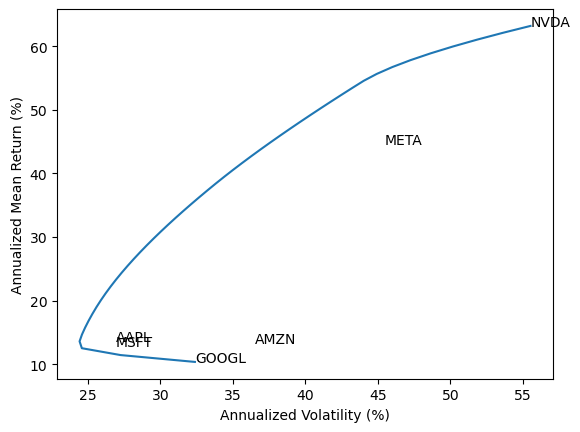

In [54]:
(
    mv_frontier
    .mul(100)
    .plot(x='volatility', y='returns_target', legend=False)
)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')

for t in Sigma.index:
    x = 100 * np.sqrt(252 * Sigma.loc[t, t])
    y = 100 * 252 * mu.loc[t]
    plt.annotate(text=t, xy=(x, y))
    
plt.show()